In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from scipy.stats import norm
from tensorflow.python.data import Dataset
from scipy import stats
from sklearn import metrics
from IPython import display
import math
%matplotlib inline

/home/whiterab22bit/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [25]:
train_data = pd.read_csv('/home/whiterab22bit/house_train.csv')
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


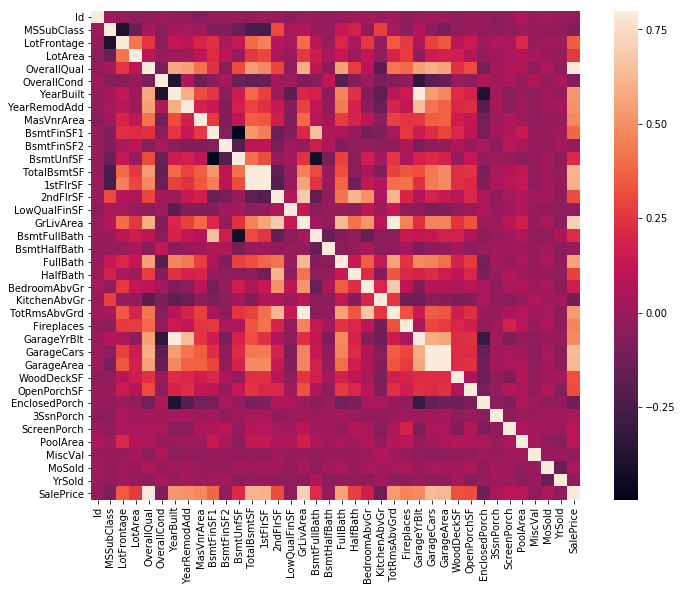

In [4]:
corralations = train_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corralations, vmax=.8, square=True);

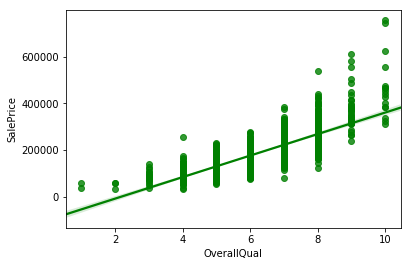

In [51]:
sns.regplot(x = 'OverallQual', y = 'SalePrice', data = train_data, color = 'Green')

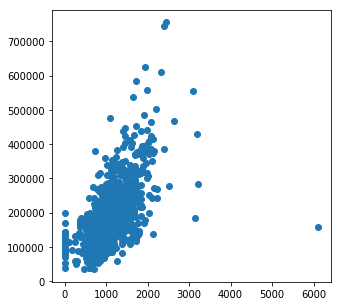

In [26]:
plt.figure(figsize=(5,5))
plt.scatter(x = train_data.TotalBsmtSF,y = train_data.SalePrice)

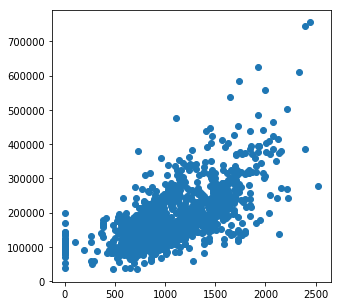

In [28]:
#one annoying outlier
train_data.drop(train_data[(train_data.TotalBsmtSF >2600)].index,inplace = True)

plt.figure(figsize=(5,5))
plt.scatter(x = train_data.TotalBsmtSF,y = train_data.SalePrice)

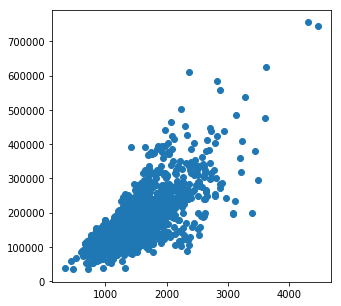

In [29]:
plt.figure(figsize=(5,5))
plt.scatter(x = train_data.GrLivArea,y = train_data.SalePrice)

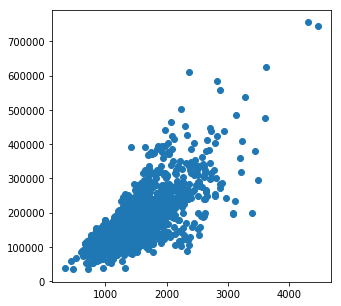

In [30]:
#have couple outliers, decided to drop them
train_data.drop(train_data[(train_data.GrLivArea >4000) & (train_data.SalePrice < 300000)].index,inplace = True)

#check
plt.figure(figsize=(5,5))
plt.scatter(x = train_data.GrLivArea,y = train_data.SalePrice)

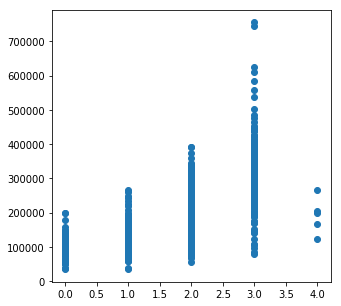

In [58]:
plt.figure(figsize=(5,5))
plt.scatter(x = train_data.GarageCars,y = train_data.SalePrice)

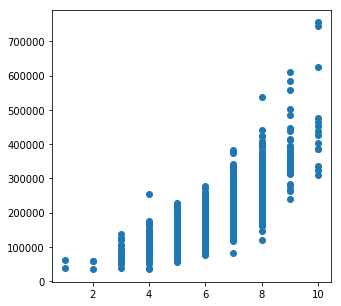

In [59]:
plt.figure(figsize=(5,5))
plt.scatter(x = train_data.OverallQual,y = train_data.SalePrice)

/home/whiterab22bit/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


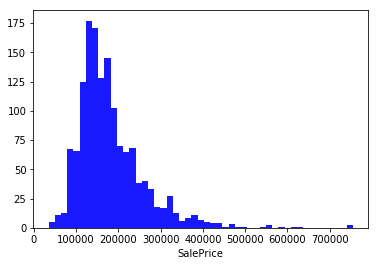

In [50]:
#label distribution is little off, will use np.log later
sns.distplot(train_data.SalePrice, kde = False, color = 'b', hist_kws={'alpha': 0.9})

In [8]:
train_data.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1367
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

In [31]:
columns = ['OverallQual',
     'GrLivArea',
     'TotalBsmtSF',
     'GarageCars',
     'FullBath',
     'TotRmsAbvGrd',]
for col in columns:
    train_data[col].fillna(0,inplace= True)

In [32]:
def preprocess_features(house_data):
    selected_features = house_data[
    ['OverallQual',
     'GrLivArea',
     'TotalBsmtSF',
     'GarageCars',
     #'FullBath',
     'TotRmsAbvGrd',]]
    processed_features = selected_features.copy()
    processed_features.GrLivArea = np.log(processed_features.GrLivArea)
    return processed_features

def preprocess_targets(house_data):
    targets = pd.DataFrame()
    targets['SalePrice'] = np.log(house_data['SalePrice'])
    
    #targets['SalePrice'] = (house_data['SalePrice'] // 1000)
    return targets

In [33]:
#training-->
training_examples = preprocess_features(train_data.head(1100))
training_targets = preprocess_targets(train_data.head(1100))

# validation -->
validation_examples = preprocess_features(train_data.tail(360))
validation_targets = preprocess_targets(train_data.tail(360))
validation_targets.info()
train_data.tail(360)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360 entries, 1098 to 1459
Data columns (total 1 columns):
SalePrice    360 non-null float64
dtypes: float64(1)
memory usage: 5.6 KB


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1098,1099,50,RM,50.0,6000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,128000
1099,1100,20,RL,82.0,11880,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,COD,Abnorml,157000
1100,1101,30,RL,60.0,8400,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,1,2009,WD,Normal,60000
1101,1102,20,RL,61.0,9758,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2007,WD,Normal,119500
1102,1103,20,RL,70.0,7000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnWw,NaN,0,4,2007,WD,Family,135000
1103,1104,20,RL,79.0,8910,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,159500
1104,1105,160,RM,24.0,2016,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2007,WD,Normal,106000
1105,1106,60,RL,98.0,12256,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,325000
1106,1107,20,RL,114.0,10357,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,179900
1107,1108,60,RL,168.0,23257,Pave,NaN,IR3,HLS,AllPub,...,0,NaN,NaN,NaN,0,9,2006,New,Partial,274725


In [34]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature)
                for my_feature in input_features])

#TotalBsmtSF: Total square feet of basement area
#GrLivArea: Above grade (ground) living area square feet
#FullBath: Full bathrooms above grade
#TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
#GarageCars: Size of garage in car capacity
#OverallQual: Rates the overall material and finish of the house 1->very poor, 10->very excellent

In [35]:
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=training_examples,
    y=training_targets,
    batch_size=50,
    num_epochs=1,
    shuffle=True)
pred_train_fn = tf.estimator.inputs.pandas_input_fn(
    x=training_examples,
    y=training_targets,
    batch_size=50,
    num_epochs=1,
    shuffle=False)

pred_val_fn = tf.estimator.inputs.pandas_input_fn(
    x=validation_examples,
    y=validation_targets,
    batch_size=50,
    num_epochs=1,
    shuffle=False)

In [36]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):

    periods = 10
    steps_per_period = steps / periods
    
   
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
    feature_columns=construct_feature_columns(training_examples),
        hidden_units=hidden_units,
        optimizer=my_optimizer,
        model_dir='/home/whiterab22bit/house_price_dir/'
    )
    
 
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        dnn_regressor.train(
            input_fn=train_input_fn,
            steps=steps_per_period
        )
    
        training_predictions = dnn_regressor.predict(input_fn=pred_train_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
        validation_predictions = dnn_regressor.predict(input_fn=pred_val_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
        
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
        
        
    print("Model training finished.")

  
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

    return dnn_regressor

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_is_chief': True, '_save_checkpoints_steps': None, '_save_summary_steps': 100, '_global_id_in_cluster': 0, '_tf_random_seed': None, '_task_id': 0, '_session_config': None, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd314781358>, '_service': None, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_train_distribute': None, '_save_checkpoints_secs': 600, '_task_type': 'worker', '_model_dir': '/home/whiterab22bit/house_price_dir/', '_device_fn': None, '_evaluation_master': '', '_keep_checkpoint_max': 5}
Training model...
RMSE (on training data):
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Savi

INFO:tensorflow:loss = 1984.4901, step = 133
INFO:tensorflow:Saving checkpoints for 154 into /home/whiterab22bit/house_price_dir/model.ckpt.
INFO:tensorflow:Loss for final step: 5086.095.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/whiterab22bit/house_price_dir/model.ckpt-154
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/whiterab22bit/house_price_dir/model.ckpt-154
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 06 : 6.23
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/whiterab22bit/house

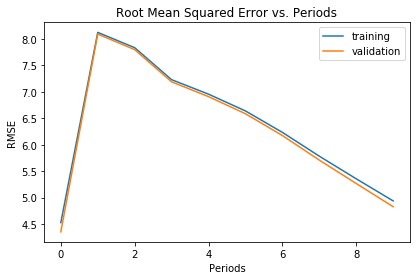

In [37]:
dnn_regressor = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.005),
    steps=2000,
    batch_size=30,
    hidden_units=[15, 15],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [69]:
test = pd.read_csv('/home/whiterab22bit/house_test.csv')
columns = ['OverallQual',
     'GrLivArea',
     'TotalBsmtSF',
     'GarageCars',
     'FullBath',
     'TotRmsAbvGrd',]
#test.isnull().sum()
for col in columns:
    test[col].fillna(0,inplace= True)
test[columns].isnull().sum()

OverallQual     0
GrLivArea       0
TotalBsmtSF     0
GarageCars      0
FullBath        0
TotRmsAbvGrd    0
dtype: int64

In [70]:
test_examples = preprocess_features(test)

In [74]:
pred_test_fn = tf.estimator.inputs.pandas_input_fn(
    x=test_examples,
    y=None,
    batch_size=50,
    num_epochs=1,
    shuffle=False)

In [75]:
test_predictions = dnn_regressor.predict(input_fn=pred_test_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/whiterab22bit/house_price_dir/model.ckpt-660
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [76]:
my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': test_predictions})
#my_submission = my_submission.apply(lambda d: d * 10000)
my_submission
my_submission.to_csv('house_price1.csv', index=False)